# **Atlántico**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd

## 1. Calidad de los datos

In [2]:
# Leer el archivo
df = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\data_atlantico.csv", encoding='latin_1', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31800 entries, 0 to 31799
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   area                   31800 non-null  int64 
 1   año                    31800 non-null  int64 
 2   edad                   31800 non-null  int64 
 3   fecha_consulta         31800 non-null  object
 4   fecha_hospitalizacion  31800 non-null  object
 5   fecha_inicio_sintomas  31800 non-null  object
 6   fecha_nacimiento       31800 non-null  object
 7   fecha_notificacion     31800 non-null  object
 8   hospitalizado          31800 non-null  int64 
 9   muerte                 31800 non-null  int64 
 10  municipio              31800 non-null  object
 11  nombre_evento          31800 non-null  object
 12  pertenencia_etnica     31800 non-null  int64 
 13  regimen_salud          31800 non-null  object
 14  semana                 31800 non-null  int64 
 15  sexo               

### Variables temporales

* Convertir fechas a datetime

In [3]:
# Lista de columnas que quieres convertir
columnas_fecha = ["fecha_consulta", "fecha_inicio_sintomas", "fecha_notificacion", "fecha_nacimiento", "fecha_hospitalizacion"]

for col in columnas_fecha:
    df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
    print(f"Columna '{col}' convertida a datetime.")

Columna 'fecha_consulta' convertida a datetime.
Columna 'fecha_inicio_sintomas' convertida a datetime.
Columna 'fecha_notificacion' convertida a datetime.
Columna 'fecha_nacimiento' convertida a datetime.
Columna 'fecha_hospitalizacion' convertida a datetime.


C:\Users\Hp\AppData\Local\Temp\ipykernel_20520\618031299.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)


### Conversión de la edad

* Crear edad en años

In [4]:
df["edad_años"] = np.where(df["uni_med_"] == 1, df["edad"],   # ya está en años
                   np.where(df["uni_med_"] == 2, df["edad"] / 12,  # meses → años
                   np.where(df["uni_med_"] == 3, df["edad"] / 365, # días → años
                            np.nan)))  # por si hay otros valores

# Opcional: redondear a 2 decimales
df["edad_años"] = df["edad_años"].round().astype('int64')


* Crear variable ciclo vital

In [5]:
def ciclo_vital(edad):
    if pd.isna(edad):
        return "Desconocido"
    elif edad < 1:
        return "Menor de 1 año"
    elif edad < 5:
        return "Primera infancia"
    elif edad < 10:
        return "Infancia"
    elif edad < 20:
        return "Adolescencia"
    elif edad < 60:
        return "Adulto"
    elif edad < 85:
        return "Adulto mayor"
    else:
        return "Ancianidad"


df["ciclo_vital"] = df["edad_años"].apply(ciclo_vital)
df['ciclo_vital'].unique()

array(['Ancianidad', 'Adolescencia', 'Adulto mayor', 'Infancia', 'Adulto',
       'Primera infancia', 'Menor de 1 año'], dtype=object)

In [6]:
df.to_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\data_atlantico.csv", 
          encoding="latin1", index=False)


### Valores faltantes

In [7]:
# Cantidad de valores nulos por variable
faltantes = df.isnull().sum()
print("\n   Valores faltantes por variable:")
print(faltantes[faltantes > 0])


   Valores faltantes por variable:
fecha_hospitalizacion    12613
fecha_nacimiento          1219
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31800 entries, 0 to 31799
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   area                   31800 non-null  int64         
 1   año                    31800 non-null  int64         
 2   edad                   31800 non-null  int64         
 3   fecha_consulta         31800 non-null  datetime64[ns]
 4   fecha_hospitalizacion  19187 non-null  datetime64[ns]
 5   fecha_inicio_sintomas  31800 non-null  datetime64[ns]
 6   fecha_nacimiento       30581 non-null  datetime64[ns]
 7   fecha_notificacion     31800 non-null  datetime64[ns]
 8   hospitalizado          31800 non-null  int64         
 9   muerte                 31800 non-null  int64         
 10  municipio              31800 non-null  object        
 11  nombre_evento          31800 non-null  object        
 12  pertenencia_etnica     31800 non-null  int64         
 13  r

### Categorizar variables

In [9]:
df['hospitalizado'].unique()
df['tipo_de_caso'].value_counts()

tipo_de_caso
2    21500
3    10210
5       90
Name: count, dtype: int64

In [10]:
mapeo = {
    'area' : {1: 'Cabecera municipal' , 2:'Centro Poblado', 3:'Rural disperso'}, 
    'hospitalizado': {1: 'Si', 2: 'No'},
    'muerte': {1: 'Vivo', 2: 'Muerto'},
    'pertenencia_etnica': {1: 'Indigena', 2: 'Rom', 3: 'Raizal', 4: 'Palenquero', 5: 'Negro', 6:'Otro'},
    'regimen_salud': {'P': 'Excepción', 'E': 'Especial', 'C': 'Contributivo', 'S': 'Subsidiado', 'N': 'No asegurado', 'I': 'Indeterminado'},
    'sexo': {'M': 'Masculino', 'F': 'Femenino'},
    'tipo_de_caso': {2: 'Probable', 3: 'Conf. por laboratorio', 5: 'Conf. por nexo'}
}

df = df.replace(mapeo)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31800 entries, 0 to 31799
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   area                   31800 non-null  object        
 1   año                    31800 non-null  int64         
 2   edad                   31800 non-null  int64         
 3   fecha_consulta         31800 non-null  datetime64[ns]
 4   fecha_hospitalizacion  19187 non-null  datetime64[ns]
 5   fecha_inicio_sintomas  31800 non-null  datetime64[ns]
 6   fecha_nacimiento       30581 non-null  datetime64[ns]
 7   fecha_notificacion     31800 non-null  datetime64[ns]
 8   hospitalizado          31800 non-null  object        
 9   muerte                 31800 non-null  object        
 10  municipio              31800 non-null  object        
 11  nombre_evento          31800 non-null  object        
 12  pertenencia_etnica     31800 non-null  object        
 13  r

## 2. Análisis univariado

In [11]:
def describir_categorica(columna, col_evento="evento"):
    # Conteos y proporciones generales
    tabla = pd.DataFrame({
        "Conteo": columna.value_counts(dropna=False),
        "Proporción": columna.value_counts(normalize=True, dropna=False).round(4)
    })

    # Renombrar índice si hay NaN
    tabla.index = tabla.index.map(lambda x: "NaN" if pd.isna(x) else x)

    # Conteos de la variable evento cruzada con la categórica
    crosstab_evento = pd.crosstab(df[columna.name], df[col_evento])

    # Unir todo
    tabla_completa = tabla.join(crosstab_evento)

    # Agregar proporciones específicas para 'Clasico' y 'Grave' si existen
    if "Clasico" in crosstab_evento.columns:
        tabla_completa["Prop_Clasico"] = (tabla_completa["Clasico"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Clasico"] = 0

    if "Grave" in crosstab_evento.columns:
        tabla_completa["Prop_Grave"] = (tabla_completa["Grave"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Grave"] = 0

    print(f"\n📌 Variable: {columna.name}")
    print(tabla_completa)
    print("\n-----------------------------------")



In [12]:
# Tabla descriptivo de numericas
def describir_numerica(columna):
    print(f"\n📌 Variable: {columna.name}")
    print(f"Min {columna.min()}")
    print(f"Max{columna.max()}")
    print(columna.max())
    print(columna.mean())
    print(columna.std())
    print(columna.median())
    print("\n-----------------------------------")

### 2.1 Variables demográficas

- Edad / Ciclo vital
- Sexo
- Pertenencia étnica
- Regimen de salud

In [13]:
print("DESCRIPCIÓN DE VARIABLES CATEGÓRICAS")
describir_categorica(df["ciclo_vital"])
describir_categorica(df["sexo"])
describir_categorica(df["pertenencia_etnica"])
describir_categorica(df["regimen_salud"])


DESCRIPCIÓN DE VARIABLES CATEGÓRICAS

📌 Variable: ciclo_vital
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
ciclo_vital                                                                   
Adolescencia       14572      0.4582    14211    361        0.9752      0.0248
Adulto              7120      0.2239     6931    189        0.9735      0.0265
Infancia            6554      0.2061     6444    110        0.9832      0.0168
Primera infancia    2784      0.0875     2737     47        0.9831      0.0169
Adulto mayor         586      0.0184      563     23        0.9608      0.0392
Menor de 1 año       135      0.0042      132      3        0.9778      0.0222
Ancianidad            49      0.0015       45      4        0.9184      0.0816

-----------------------------------

📌 Variable: sexo
           Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
sexo                                                                   
Masculino   16724      0.525

In [14]:
# Gráficos de variables categóricas
def graficar_categorica(var, nombre_grafico, df):
    plt.figure(figsize=(10, 4))
    plt.title(nombre_grafico, fontsize=14, fontweight='bold', pad=15)
    
    conteo = df[var].value_counts(dropna=False)
    sns.barplot(x=conteo.index.astype(str), y=conteo.values, color='#2E4265')
    
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=0)
    plt.ylim(0, max(conteo.values) * 1.1)
    
    plt.tight_layout()
    plt.show()


In [15]:
# Gráficos de variables categóricas - Pie
def graficar_categorica_pie(var, nombre_grafico, df):
    plt.figure(figsize=(6, 4))
    plt.title(nombre_grafico, fontsize=14, fontweight='bold', pad=15)

    conteo = df[var].value_counts(dropna=False)

    # Pie chart
    plt.pie(
        conteo.values,
        labels=conteo.index.astype(str),
        autopct='%1.1f%%',   # porcentajes con 1 decimal
        startangle=90,       # para que arranque desde arriba
        colors=sns.color_palette("Set3", len(conteo))  # paleta de colores
    )

    plt.axis('equal')  # Para que sea un círculo perfecto
    plt.tight_layout()
    plt.show()


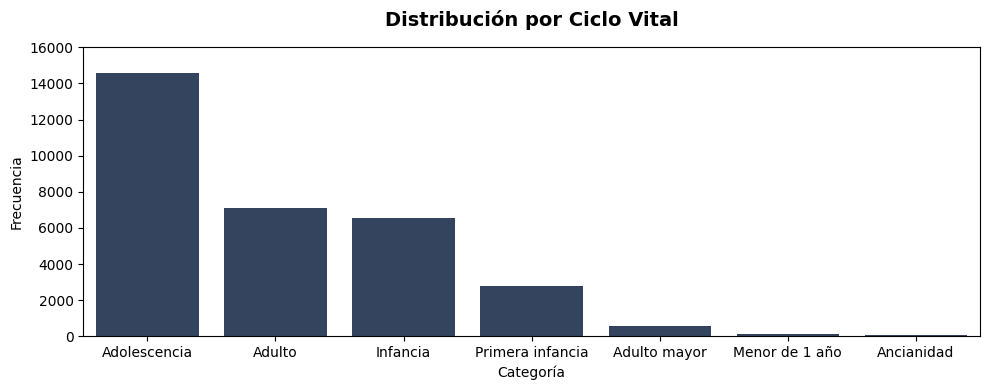

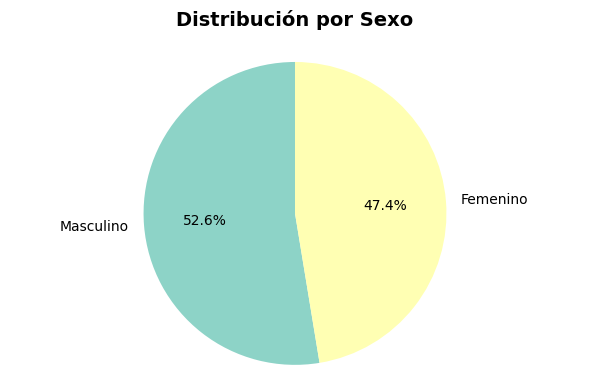

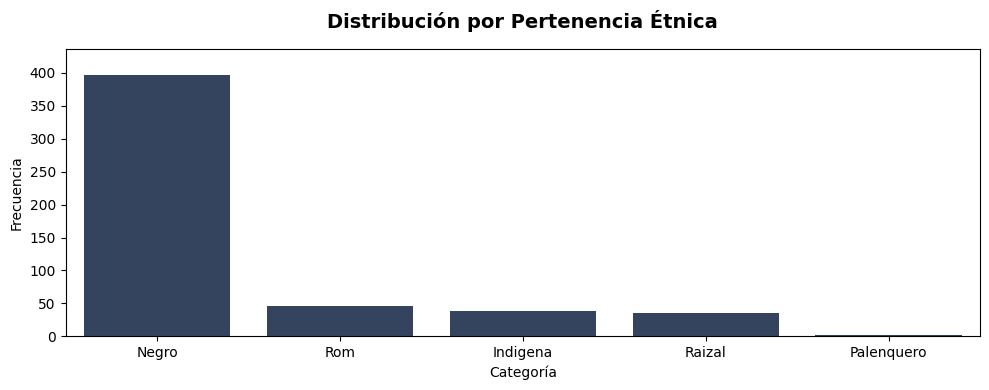

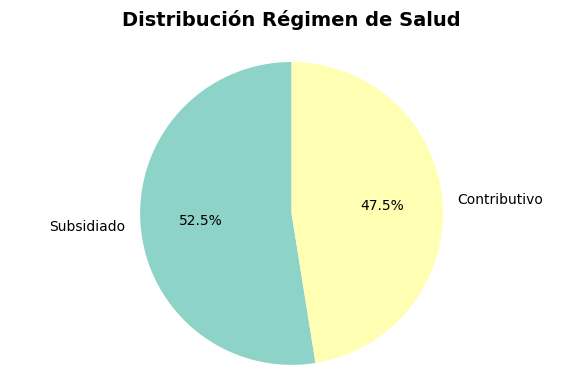

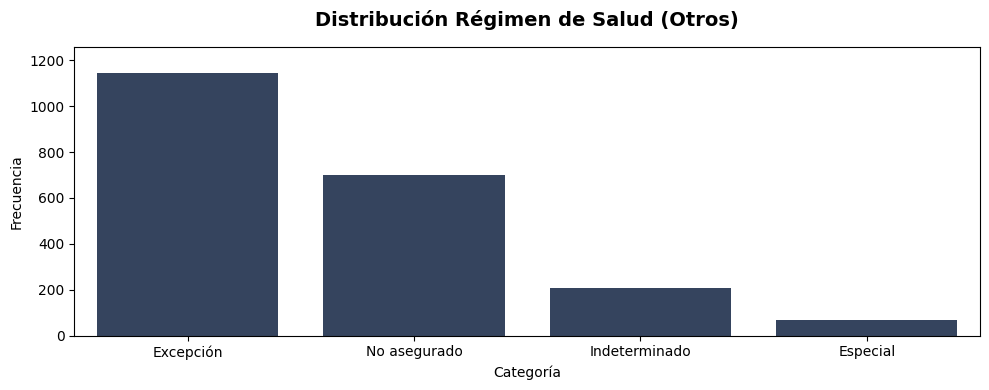

In [16]:
graficar_categorica("ciclo_vital", "Distribución por Ciclo Vital", df)
graficar_categorica_pie("sexo", "Distribución por Sexo", df)

etnia_filtrada = df[df["pertenencia_etnica"] != "Otro"]
graficar_categorica('pertenencia_etnica', "Distribución por Pertenencia Étnica", etnia_filtrada)

df_regimen_principal = df[df["regimen_salud"].isin(["Contributivo", "Subsidiado"])]
df_regimen_otros = df[~df["regimen_salud"].isin(["Contributivo", "Subsidiado"])]
graficar_categorica_pie("regimen_salud", "Distribución Régimen de Salud", df_regimen_principal)
graficar_categorica("regimen_salud", "Distribución Régimen de Salud (Otros)", df_regimen_otros)

* Edad

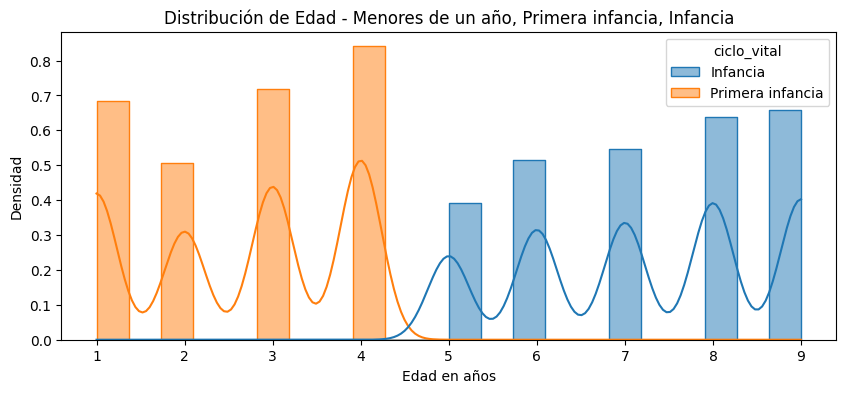

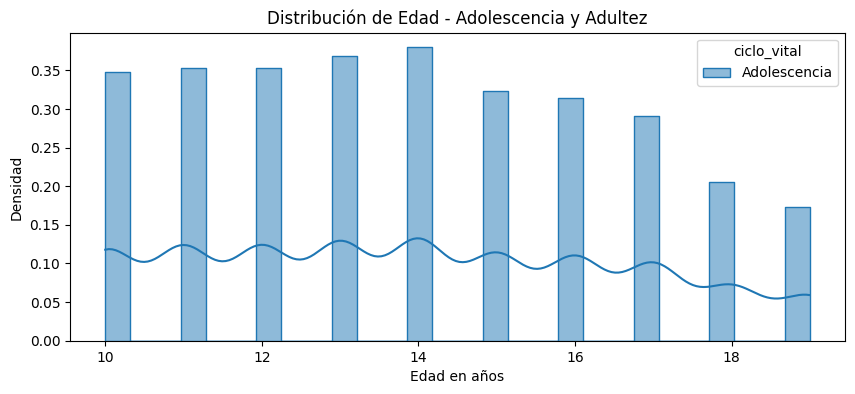

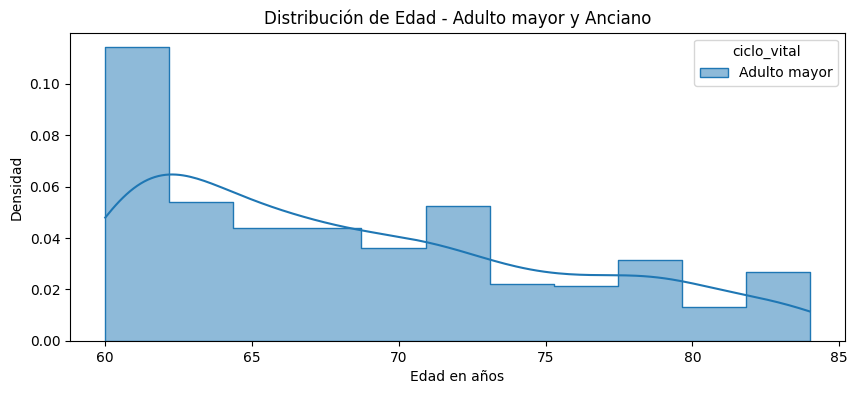

In [17]:
# Grupo 1: menores de un año, primera infancia, infancia
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df[df["ciclo_vital"].isin(["Menores de un año", "Primera infancia", "Infancia"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Menores de un año, Primera infancia, Infancia")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()

# Grupo 2: adolescencia y adultez
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df[df["ciclo_vital"].isin(["Adolescencia", "Adultez"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Adolescencia y Adultez")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()

# Grupo 3: adulto mayor y anciano
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df[df["ciclo_vital"].isin(["Adulto mayor", "Anciano"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Adulto mayor y Anciano")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()


In [18]:
tabla_resumen = df.groupby("ciclo_vital")["edad_años"].describe()
tabla_resumen

,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,14572.0,13.996912,2.680334,10.0,12.0,14.0,16.0,19.0
Adulto,7120.0,30.107303,10.079262,20.0,22.0,27.0,35.0,59.0
Adulto mayor,586.0,68.622867,6.908641,60.0,63.0,67.0,73.0,84.0
Ancianidad,49.0,89.387755,4.157405,85.0,86.0,88.0,91.0,100.0
Infancia,6554.0,7.239396,1.374341,5.0,6.0,7.0,8.0,9.0
Menor de 1 año,135.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Primera infancia,2784.0,2.622845,1.159873,1.0,2.0,3.0,4.0,4.0


In [19]:
# Tabla para evento Clásico
tabla_clasico = df[df["evento"] == "Clasico"].groupby("ciclo_vital")["edad_años"].describe()

# Tabla para evento Grave
tabla_grave = df[df["evento"] == "Grave"].groupby("ciclo_vital")["edad_años"].describe()

print("📌 Evento: Clasico")
tabla_clasico

📌 Evento: Clasico


,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,14211.0,13.985786,2.678755,10.0,12.0,14.0,16.0,19.0
Adulto,6931.0,30.143702,10.101397,20.0,22.0,27.0,35.0,59.0
Adulto mayor,563.0,68.660746,6.954888,60.0,62.5,67.0,74.0,84.0
Ancianidad,45.0,89.088889,3.935978,85.0,86.0,88.0,91.0,100.0
Infancia,6444.0,7.235413,1.374581,5.0,6.0,7.0,8.0,9.0
Menor de 1 año,132.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Primera infancia,2737.0,2.619657,1.159291,1.0,2.0,3.0,4.0,4.0


In [20]:
print("📌 Evento: Grave")
tabla_grave


📌 Evento: Grave


,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,361.0,14.434903,2.709408,10.0,12.00,14.0,17.0,19.0
Adulto,189.0,28.772487,9.155633,20.0,22.00,26.0,32.0,57.0
Adulto mayor,23.0,67.695652,5.708326,61.0,63.00,67.0,69.5,82.0
Ancianidad,4.0,92.750000,5.737305,85.0,90.25,94.0,96.5,98.0
Infancia,110.0,7.472727,1.345799,5.0,6.00,8.0,9.0,9.0
Menor de 1 año,3.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
Primera infancia,47.0,2.808511,1.191242,1.0,2.00,3.0,4.0,4.0


### 2.2 Variables de evento



In [21]:
describir_categorica(df['evento'])
describir_categorica(df['tipo_de_caso'])
describir_categorica(df['hospitalizado'])
describir_categorica(df['muerte'])


📌 Variable: evento
         Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
evento                                                               
Clasico   31063      0.9768    31063      0           1.0         0.0
Grave       737      0.0232        0    737           0.0         1.0

-----------------------------------

📌 Variable: tipo_de_caso
                       Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
tipo_de_caso                                                              
Probable                21500      0.6761    20976    524        0.9756   
Conf. por laboratorio   10210      0.3211     9997    213        0.9791   
Conf. por nexo             90      0.0028       90      0        1.0000   

                       Prop_Grave  
tipo_de_caso                       
Probable                   0.0244  
Conf. por laboratorio      0.0209  
Conf. por nexo             0.0000  

-----------------------------------

📌 Variable: hospitalizado
               Co

### 2.3 Variables temporales

In [22]:
describir_categorica(df["año"])


📌 Variable: año
      Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
año                                                               
2022   10481      0.3296    10148    333        0.9682      0.0318
2021    7851      0.2469     7663    188        0.9761      0.0239
2019    3963      0.1246     3905     58        0.9854      0.0146
2018    3293      0.1036     3246     47        0.9857      0.0143
2020    2656      0.0835     2613     43        0.9838      0.0162
2023    2360      0.0742     2331     29        0.9877      0.0123
2017    1196      0.0376     1157     39        0.9674      0.0326

-----------------------------------


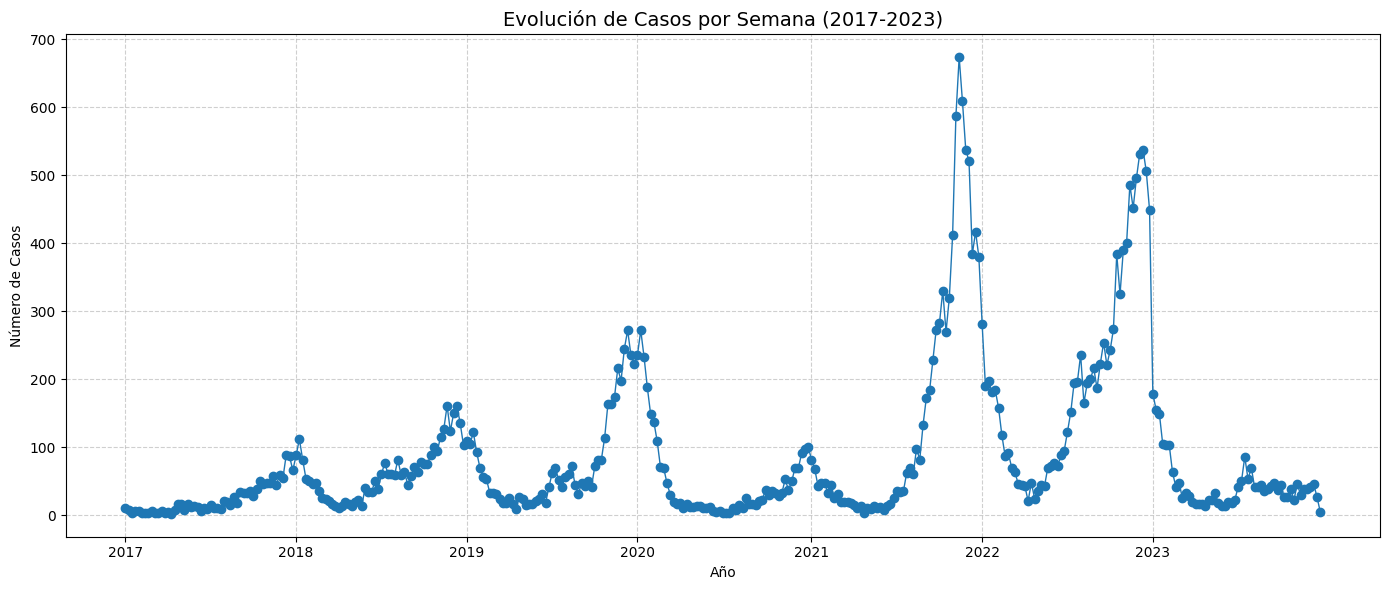

In [23]:
# Agrupar por año y semana
casos_semana = df.groupby(["año", "semana"]).size().reset_index(name="casos")

# Ordenar
casos_semana = casos_semana.sort_values(["año", "semana"]).reset_index(drop=True)

# Crear índice continuo
casos_semana["index"] = range(len(casos_semana))

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(casos_semana["index"], casos_semana["casos"], marker="o", linewidth=1)

# Marcar solo los años en el eje X
años_unicos = casos_semana["año"].unique()
ticks = [casos_semana[casos_semana["año"] == año].index[0] for año in años_unicos]
plt.xticks(ticks, años_unicos, fontsize=10)

plt.title("Evolución de Casos por Semana (2017-2023)", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Número de Casos")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 2.4 Variables espaciales

In [24]:
describir_categorica(df["area"])
describir_categorica(df['municipio'])


📌 Variable: area
                    Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
area                                                                   
Cabecera municipal   31129      0.9789    30406    723        0.9768   
Centro Poblado         588      0.0185      575     13        0.9779   
Rural disperso          83      0.0026       82      1        0.9880   

                    Prop_Grave  
area                            
Cabecera municipal      0.0232  
Centro Poblado          0.0221  
Rural disperso          0.0120  

-----------------------------------

📌 Variable: municipio
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
municipio                                                                     
BARRANQUILLA       16743      0.5265    16397    346        0.9793      0.0207
SOLEDAD             6997      0.2200     6841    156        0.9777      0.0223
MALAMBO             1697      0.0534     1657     40        0.9764      0.0236
S

## Exploración binaria

## 3. MAPAS

In [25]:
# REELEER DATA
df = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\data_atlantico.csv", encoding='latin_1', low_memory=False)
df.columns = df.columns.str.upper()

# Población proyectada
poblacion = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\tabla_municipios.csv", encoding='utf_8', low_memory=False)

# Shapefile de Atlántico
gdf = gpd.read_file(r"C:\Users\Hp\DENGUE\Data\dengue_data\atlantico_municipios.shp", encoding='utf_8')
gdf = gdf.rename(columns={'mpio_cnmbr': 'MUNICIPIO'})

In [26]:
df['MUNICIPIO'].unique()

array(['BARRANQUILLA', 'SOLEDAD', 'REPELÓN', 'JUAN DE ACOSTA', 'GALAPA',
       'USIACURÍ', 'BARANOA', 'POLONUEVO', 'SABANALARGA', 'SABANAGRANDE',
       'MALAMBO', 'LURUACO', 'CAMPO DE LA CRUZ', 'SANTO TOMÁS',
       'desconocido', 'TUBARÁ', 'PONEDERA', 'PUERTO COLOMBIA', 'MANATÍ',
       'CANDELARIA', 'PALMAR DE VARELA', 'SUAN', 'PIOJÓ', 'SANTA LUCÍA'],
      dtype=object)

In [27]:
poblacion['MUNICIPIO'].unique()

array(['BARANOA', 'BARRANQUILLA', 'CAMPO DE LA CRUZ', 'CANDELARIA',
       'GALAPA', 'JUAN DE ACOSTA', 'LURUACO', 'MALAMBO', 'MANATÍ',
       'PALMAR DE VARELA', 'PIOJÓ', 'POLONUEVO', 'PONEDERA',
       'PUERTO COLOMBIA', 'REPELÓN', 'SABANAGRANDE', 'SABANALARGA',
       'SANTA LUCÍA', 'SANTO TOMÁS', 'SOLEDAD', 'SUAN', 'TUBARÁ',
       'USIACURÍ'], dtype=object)

In [28]:
# Agrupamos casos por municipio, año y evento
casos = df.groupby(["MUNICIPIO", "AÑO", "EVENTO"]).size().reset_index(name="casos")
# Total acumulado (sin año, solo municipio y evento)
casos_total = df.groupby(["MUNICIPIO", "EVENTO"]).size().reset_index(name="casos")
print(casos_total)

           MUNICIPIO   EVENTO  casos
0            BARANOA  Clasico   1008
1            BARANOA    Grave     20
2       BARRANQUILLA  Clasico  16397
3       BARRANQUILLA    Grave    346
4   CAMPO DE LA CRUZ  Clasico    144
5   CAMPO DE LA CRUZ    Grave      7
6         CANDELARIA  Clasico     52
7         CANDELARIA    Grave      3
8             GALAPA  Clasico    845
9             GALAPA    Grave     31
10    JUAN DE ACOSTA  Clasico    246
11    JUAN DE ACOSTA    Grave      6
12           LURUACO  Clasico    278
13           LURUACO    Grave      6
14           MALAMBO  Clasico   1657
15           MALAMBO    Grave     40
16            MANATÍ  Clasico    250
17            MANATÍ    Grave      7
18  PALMAR DE VARELA  Clasico    108
19  PALMAR DE VARELA    Grave      2
20             PIOJÓ  Clasico     67
21             PIOJÓ    Grave      2
22         POLONUEVO  Clasico    395
23         POLONUEVO    Grave      4
24          PONEDERA  Clasico    186
25          PONEDERA    Grave      3
2

In [29]:
# Filtrar datos sin Barranquilla
df_q = df[df["MUNICIPIO"] != "BARRANQUILLA"]

# Agrupar por municipio, año y evento
tabla = df_q.groupby(["MUNICIPIO","AÑO","EVENTO"]).size().reset_index(name="casos")
tabla['AÑO'].unique()

array([2017, 2018, 2019, 2020, 2021, 2022, 2023])

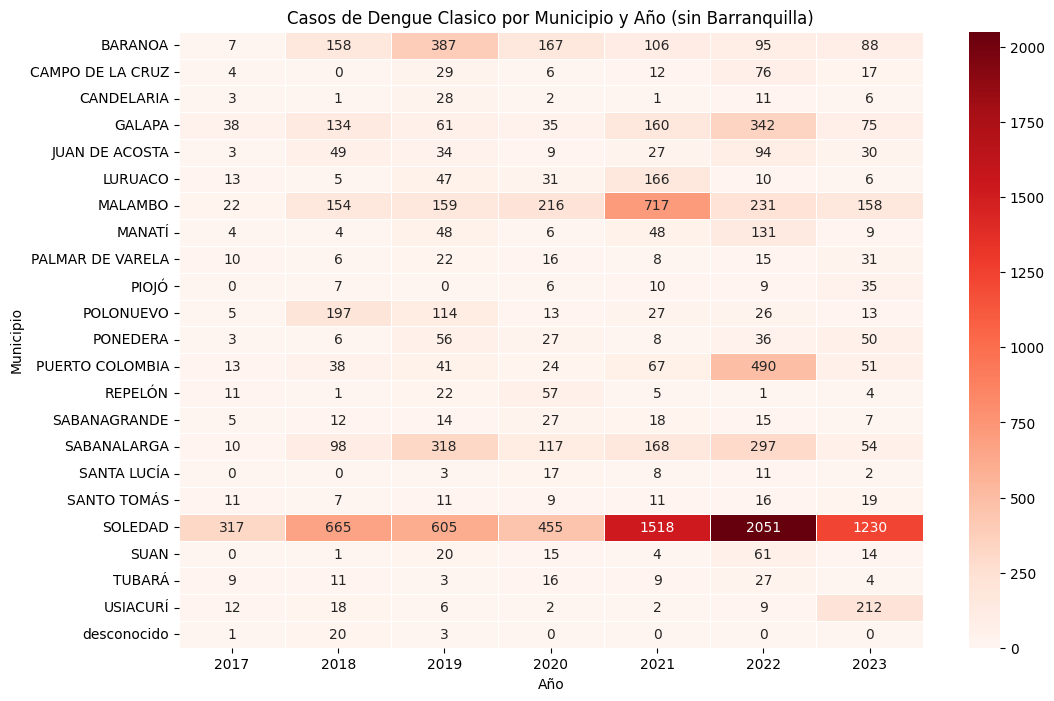

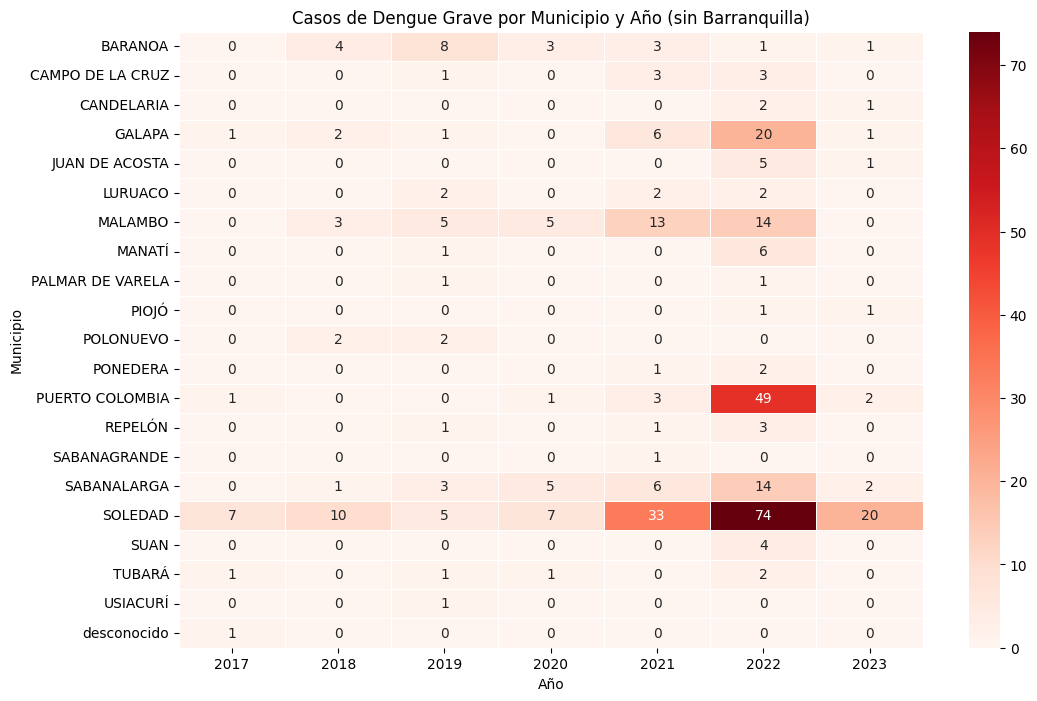

In [30]:

# Lista de eventos a graficar
eventos = ["Clasico", "Grave"]

for evento in eventos:
    # Filtrar solo el evento actual
    tabla_evento = tabla[tabla["EVENTO"] == evento]
    
    # Crear tabla pivote para heatmap
    pivot = tabla_evento.pivot_table(
        index="MUNICIPIO", 
        columns="AÑO", 
        values="casos", 
        fill_value=0
    )
    pivot = pivot.fillna(0).astype(int)
    
    # Graficar heatmap
    plt.figure(figsize=(12,8))
    sns.heatmap(pivot, cmap="Reds", linewidths=0.5, annot=True, fmt="d")
    plt.title(f"Casos de Dengue {evento} por Municipio y Año (sin Barranquilla)")
    plt.xlabel("Año")
    plt.ylabel("Municipio")
    plt.show()

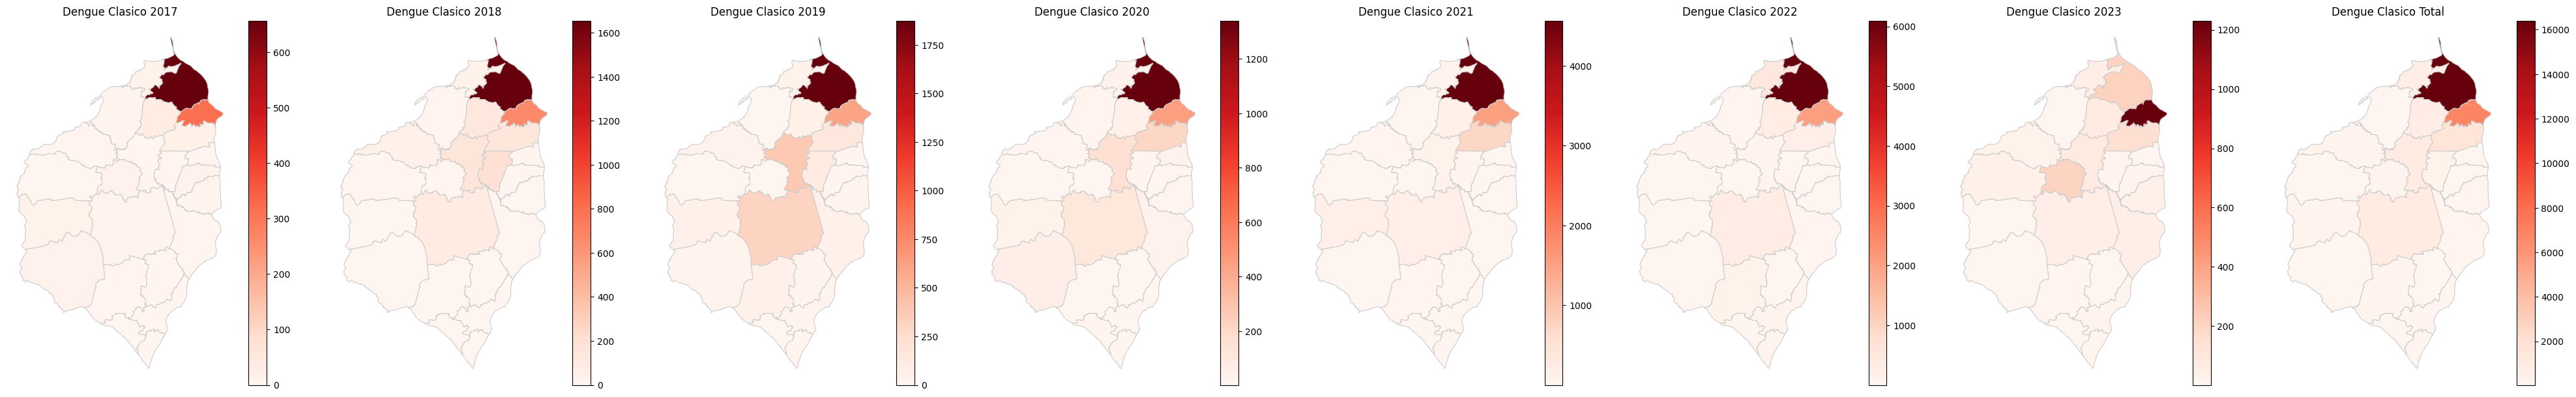

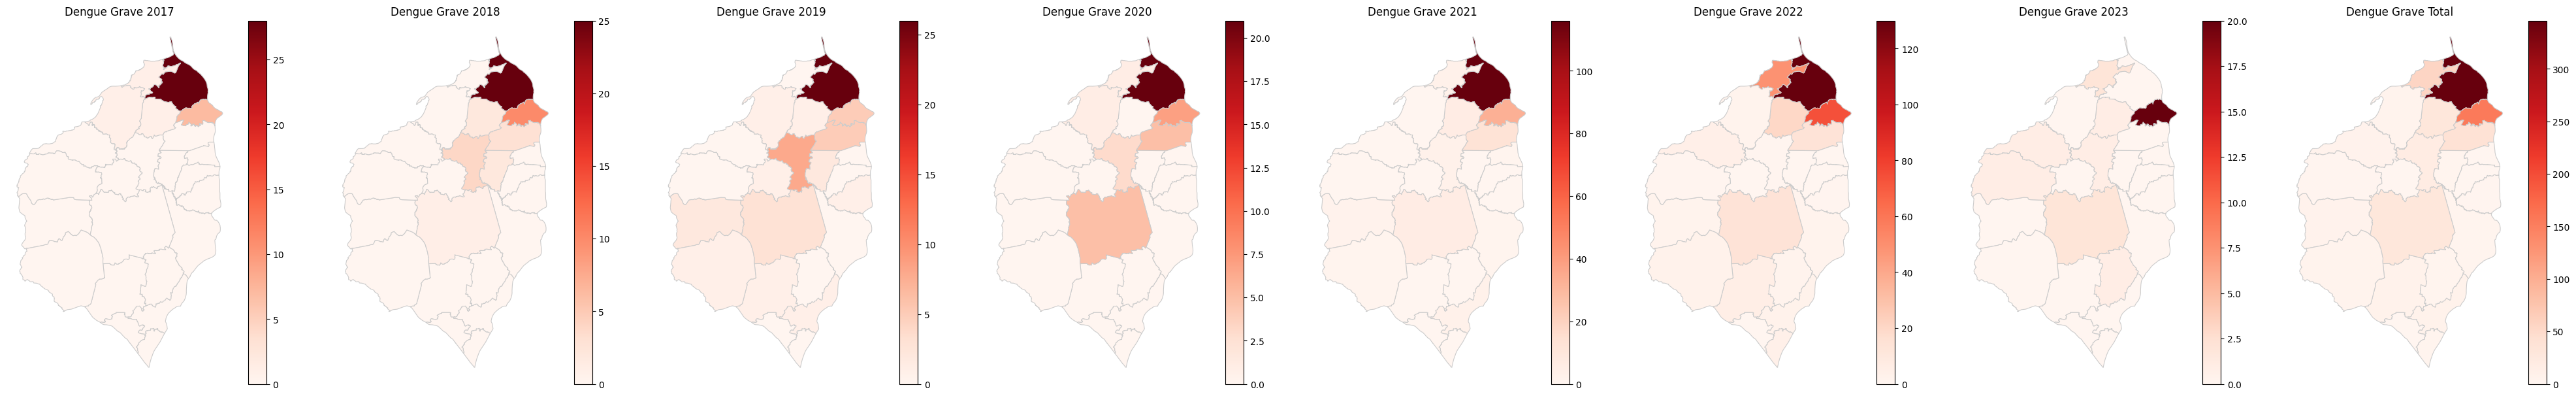

In [31]:
eventos = ["Clasico", "Grave"]

for evento in eventos:
    anios = sorted(df["AÑO"].unique())
    n = len(anios) + 1  # años + total

    fig, axes = plt.subplots(1, n, figsize=(5*n, 6))

    for i, anio in enumerate(anios):
        casos_anio = df[(df["AÑO"] == anio) & (df["EVENTO"] == evento)]
        casos_anio = casos_anio.groupby("MUNICIPIO").size().reset_index(name="CASOS")
        gdf_plot = gdf.merge(casos_anio, on="MUNICIPIO", how="left").fillna(0)
        
        gdf_plot.plot(column="CASOS", cmap="Reds", linewidth=0.8, edgecolor="0.8",
                      legend=True, ax=axes[i])
        axes[i].set_title(f"Dengue {evento} {anio}")
        axes[i].axis("off")

    # Total de casos por evento
    casos_total = df[df["EVENTO"] == evento].groupby("MUNICIPIO").size().reset_index(name="CASOS")
    gdf_total = gdf.merge(casos_total, on="MUNICIPIO", how="left").fillna(0)

    gdf_total.plot(column="CASOS", cmap="Reds", linewidth=0.8, edgecolor="0.8",
                   legend=True, ax=axes[-1])
    axes[-1].set_title(f"Dengue {evento} Total")
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()


## Tasa de incidencia

In [32]:
# Supongamos que tu tabla de población se llama df_poblacion
df_poblacion_long = poblacion.melt(
    id_vars="MUNICIPIO",
    value_vars=['2017.0','2018.0','2019.0','2020.0','2021.0','2022.0','2023.0'],
    var_name="AÑO",
    value_name="POBLACION"
)

# Limpiar el año (quitar ".0")
df_poblacion_long["AÑO"] = df_poblacion_long["AÑO"].str.replace(".0", "", regex=False).astype(int)
df_poblacion_long

,MUNICIPIO,AÑO,POBLACION
0,BARANOA,2017,60676.0
1,BARRANQUILLA,2017,1180860.0
2,CAMPO DE LA CRUZ,2017,22604.0
3,CANDELARIA,2017,15543.0
4,GALAPA,2017,58493.0
...,...,...,...
156,SANTO TOMÁS,2023,35083.0
157,SOLEDAD,2023,696982.0
158,SUAN,2023,13814.0
159,TUBARÁ,2023,19692.0


In [33]:
df_incidencia = pd.merge(
    casos,
    df_poblacion_long,
    on=["MUNICIPIO","AÑO"],
    how="left"
)
df_incidencia

,MUNICIPIO,AÑO,EVENTO,casos,POBLACION
0,BARANOA,2017,Clasico,7,60676.0
1,BARANOA,2018,Clasico,158,62371.0
2,BARANOA,2018,Grave,4,62371.0
3,BARANOA,2019,Clasico,387,64550.0
4,BARANOA,2019,Grave,8,64550.0
...,...,...,...,...,...
225,USIACURÍ,2023,Clasico,212,14627.0
226,desconocido,2017,Clasico,1,NaN
227,desconocido,2017,Grave,1,NaN
228,desconocido,2018,Clasico,20,NaN


In [34]:
df_incidencia["TASA_INCIDENCIA"] = (df_incidencia["casos"] / df_incidencia["POBLACION"]) * 100000
df_incidencia

,MUNICIPIO,AÑO,EVENTO,casos,POBLACION,TASA_INCIDENCIA
0,BARANOA,2017,Clasico,7,60676.0,11.536687
1,BARANOA,2018,Clasico,158,62371.0,253.322858
2,BARANOA,2018,Grave,4,62371.0,6.413237
3,BARANOA,2019,Clasico,387,64550.0,599.535244
4,BARANOA,2019,Grave,8,64550.0,12.393493
...,...,...,...,...,...,...
225,USIACURÍ,2023,Clasico,212,14627.0,1449.374445
226,desconocido,2017,Clasico,1,NaN,NaN
227,desconocido,2017,Grave,1,NaN,NaN
228,desconocido,2018,Clasico,20,NaN,NaN


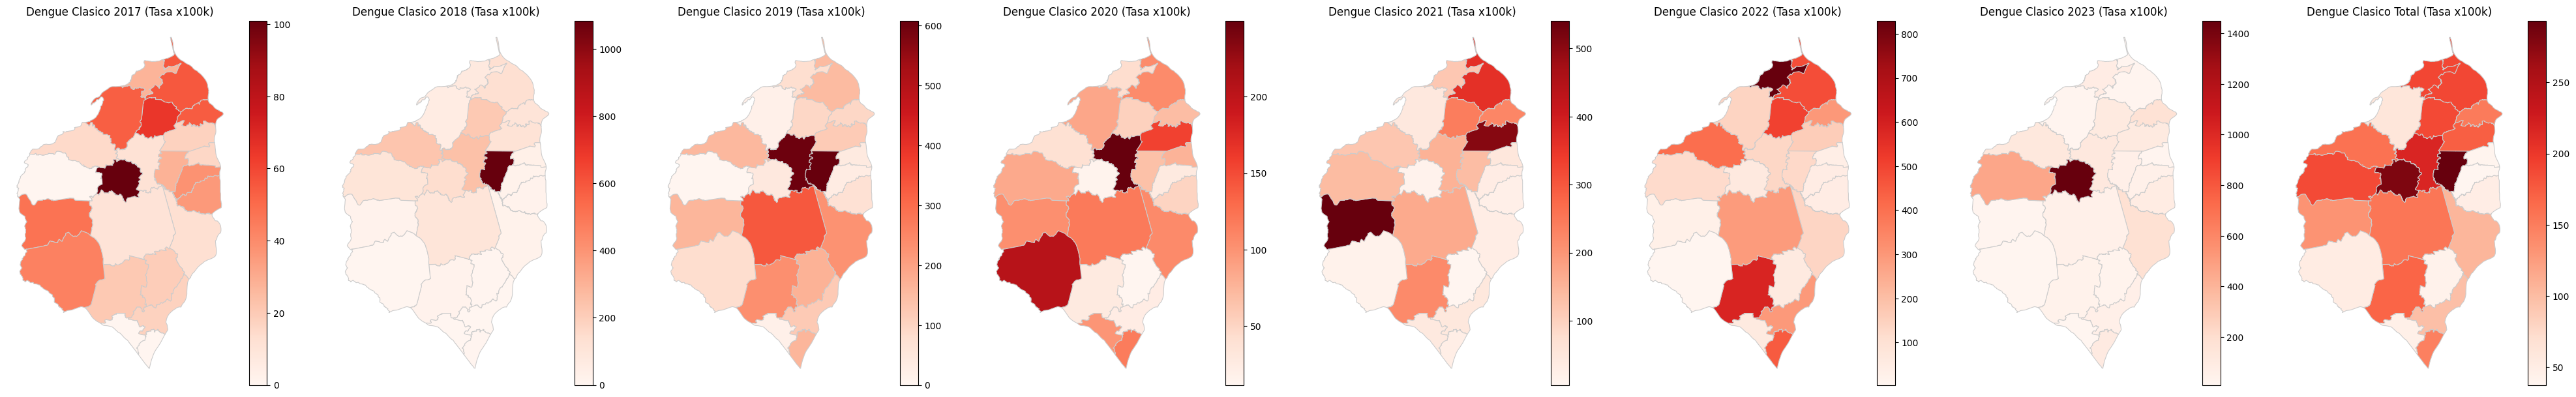

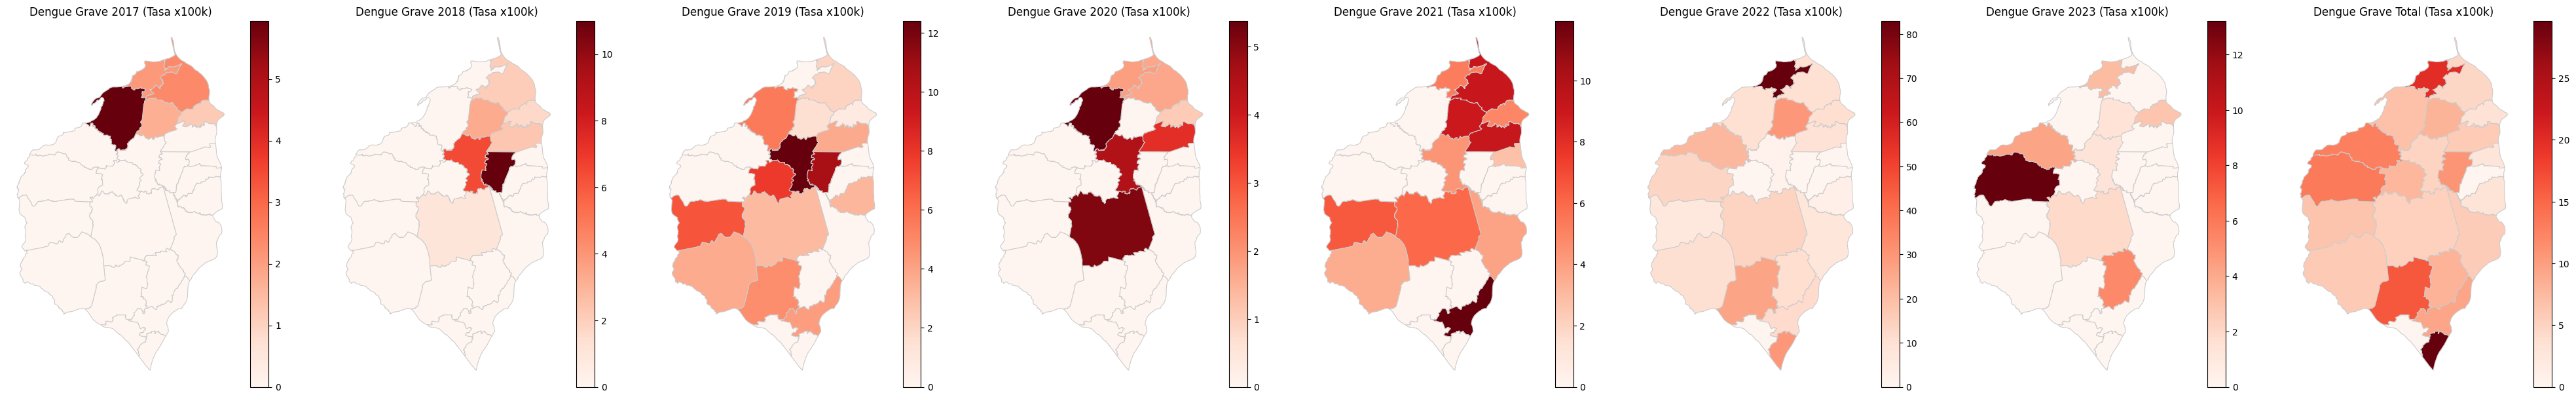

In [35]:
for evento in ["Clasico","Grave"]:
    anios = sorted(df_incidencia["AÑO"].unique())
    n = len(anios) + 1

    fig, axes = plt.subplots(1, n, figsize=(5*n, 6))

    for i, anio in enumerate(anios):
        casos_anio = df_incidencia[(df_incidencia["AÑO"] == anio) & (df_incidencia["EVENTO"] == evento)]
        gdf_plot = gdf.merge(casos_anio, on="MUNICIPIO", how="left").fillna(0)

        gdf_plot.plot(column="TASA_INCIDENCIA", cmap="Reds", linewidth=0.8, edgecolor="0.8",
                      legend=True, ax=axes[i])
        axes[i].set_title(f"Dengue {evento} {anio} (Tasa x100k)")
        axes[i].axis("off")

    # Total acumulado
    casos_total = df_incidencia[df_incidencia["EVENTO"] == evento].groupby("MUNICIPIO").agg({
        "casos":"sum",
        "POBLACION":"sum"
    }).reset_index()
    casos_total["TASA_INCIDENCIA"] = (casos_total["casos"] / casos_total["POBLACION"]) * 100000

    gdf_total = gdf.merge(casos_total, on="MUNICIPIO", how="left").fillna(0)

    gdf_total.plot(column="TASA_INCIDENCIA", cmap="Reds", linewidth=0.8, edgecolor="0.8",
                   legend=True, ax=axes[-1])
    axes[-1].set_title(f"Dengue {evento} Total (Tasa x100k)")
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()


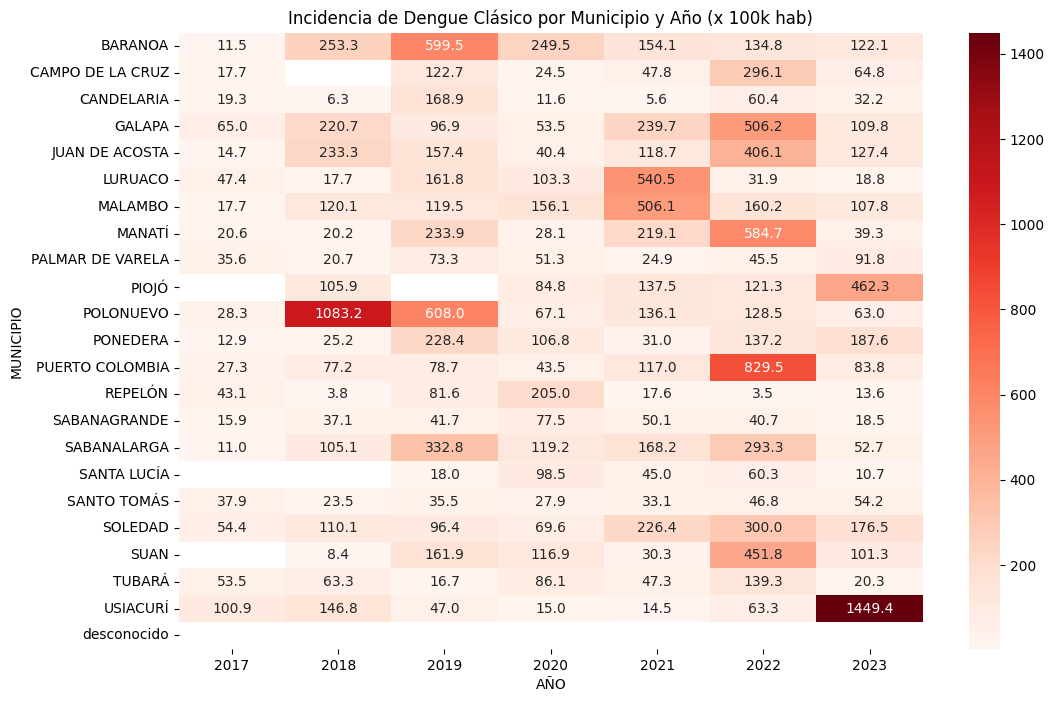

In [36]:
# Filtrar por evento y excluir Barranquilla
df_heat = df_incidencia[(df_incidencia["EVENTO"] == "Clasico") & (df_incidencia["MUNICIPIO"] != "BARRANQUILLA")]

# Pivotear para heatmap
heatmap_data = df_heat.pivot(index="MUNICIPIO", columns="AÑO", values="TASA_INCIDENCIA")

# Graficar
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt=".1f")
plt.title("Incidencia de Dengue Clásico por Municipio y Año (x 100k hab)")
plt.show()

4. Exploración bivariada (comparaciones)

4.1 Demografía vs evento/desenlace

Edad × hospitalización.

Sexo × tipo de caso.

Aseguradora × mortalidad.

4.2 Geografía vs desenlace

Municipios/localidades con mayor hospitalización o mortalidad.

Tasas de casos por 100.000 hab.

4.3 Temporalidad vs desenlace

Hospitalización y mortalidad por año y semana.

Comparaciones antes/después de picos epidémicos.

5. Pruebas estadísticas

Pruebas de proporción:

Diferencia en proporciones de hospitalización por sexo.

Diferencia en proporciones de mortalidad entre municipios/localidades.

Chi-cuadrado de independencia:

Sexo × tipo de caso.

Edad (categorías) × hospitalización.

Municipio × mortalidad.

Pruebas de medias:

Diferencia en promedio de edad entre hospitalizados vs no hospitalizados.

Diferencia en diferencia de días (síntomas→consulta) por municipio.

6. Análisis multivariado

Correlación entre variables numéricas

Edad, diferencia de días, semana.

Heatmap de correlaciones.

Análisis de correspondencias múltiples (ACM/MCA)

Para variables categóricas: sexo, etnia, aseguradora, municipio/localidad.

Ver si aparecen perfiles de pacientes.

Clustering exploratorio (opcional)

Agrupar barrios/localidades por perfil de casos.

7. Resumen y hallazgos clave

Principales patrones encontrados.

Variables críticas para explicar hospitalización y mortalidad.

Brechas de información (faltantes o inconsistencias).